In [89]:
import sys
import os
os.chdir("/home/jonfrey/ASL")
sys.path.append("""/home/jonfrey/ASL/src/""")
sys.path.append("""/home/jonfrey/ASL/src/pseudo_label""")

import numpy as np
from visu import Visualizer
import imageio


# STD
import os
import copy

# MISC
import numpy as np
import torch
import imageio
import cv2
from PIL import Image

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.patches as patches

from PIL import Image
import cv2
import torch
from torchvision import transforms as tf
from utils_asl import LabelLoaderAuto

lla = LabelLoaderAuto(root_scannet="/home/jonfrey/Datasets/scannet")

from pathlib import Path
import copy
import numpy as np

class AccMonitor():
    def __init__(self):
        self.metrics = {}
        self.metric_dict = {'correct': 0,
                            'correct_valid': 0,
                            'correct_valid_both': 0,
                            'total': 0, 
                            'total_valid':0,
                            'total_valid_both':0,
                            'images': 0}
    def register(self,name):
        self.metrics[name] = copy.deepcopy(self.metric_dict)
        
    def update(self,name, label, gt):
        if name not in self.metrics.keys():
            self.register(name)
        m1 = gt != -1
        self.metrics[name]["total_valid"] += (m1).sum()
        self.metrics[name]["correct_valid"] += np.sum(gt[m1] == label[m1])
        
        m2 = (gt != -1 )*(label != -1)
        self.metrics[name]["total_valid_both"] += (m2).sum()
        self.metrics[name]["correct_valid_both"] += np.sum(gt[m2] == label[m2])
        
        self.metrics[name]["total"] += gt.size
        self.metrics[name]["correct"] += np.sum(gt == label)
        self.metrics[name]["images"] += 1
        
    def __str__(self):
        s = "Acc-Monitor:\n"
        for k in self.metrics.keys():
            acc = self.metrics[k]['correct_valid'] / self.metrics[k]['total_valid']
            acc2 = self.metrics[k]['correct_valid_both'] / self.metrics[k]['total_valid_both']
            s += f"  {k}: Nr-Images: {self.metrics[k]['images']} , Avg-Acc: {acc}  Avg-Acc: valid both {acc2} \n"  
        return s
        
accm = AccMonitor()
visu = Visualizer("/home/jonfrey/Documents/master_thesis/Report/images/regu", logger=None, epoch=0, store=False, num_classes=41)

def get_labels(p,sub=1,la="png"):
    p = [str(s) for s in Path(p).rglob(f'*.{la}') if str(s).find("_.png") == -1]
    
    p.sort(
        key=lambda x: int(x.split("/")[-1][:-4])
    )
    
    return p[::sub]

gt_p = get_labels("/home/jonfrey/Datasets/scannet/scans/scene0000_00/label-filt",sub=10)

img_p = get_labels("/home/jonfrey/Datasets/scannet/scans/scene0000_00/color",sub=10, la="jpg")

#labels_desilation2_09 = get_labels("/home/jonfrey/Datasets/labels_generated/desilation2_09/scans/scene0000_00")
labels_52_retrained =  get_labels("/home/jonfrey/Datasets/labels_generated/labels_pretrain_retrain_52/scans/scene0000_00")
#labels_52_repro = get_labels("/home/jonfrey/Datasets/labels_generated/labels_52/scans/scene0000_00")

img_p

['/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/0.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/10.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/20.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/30.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/40.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/50.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/60.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/70.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/80.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/90.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/100.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/110.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/120.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/130.jpg',
 '/home/jonfrey/Datasets/scannet/scans/scene0000_00/color/1

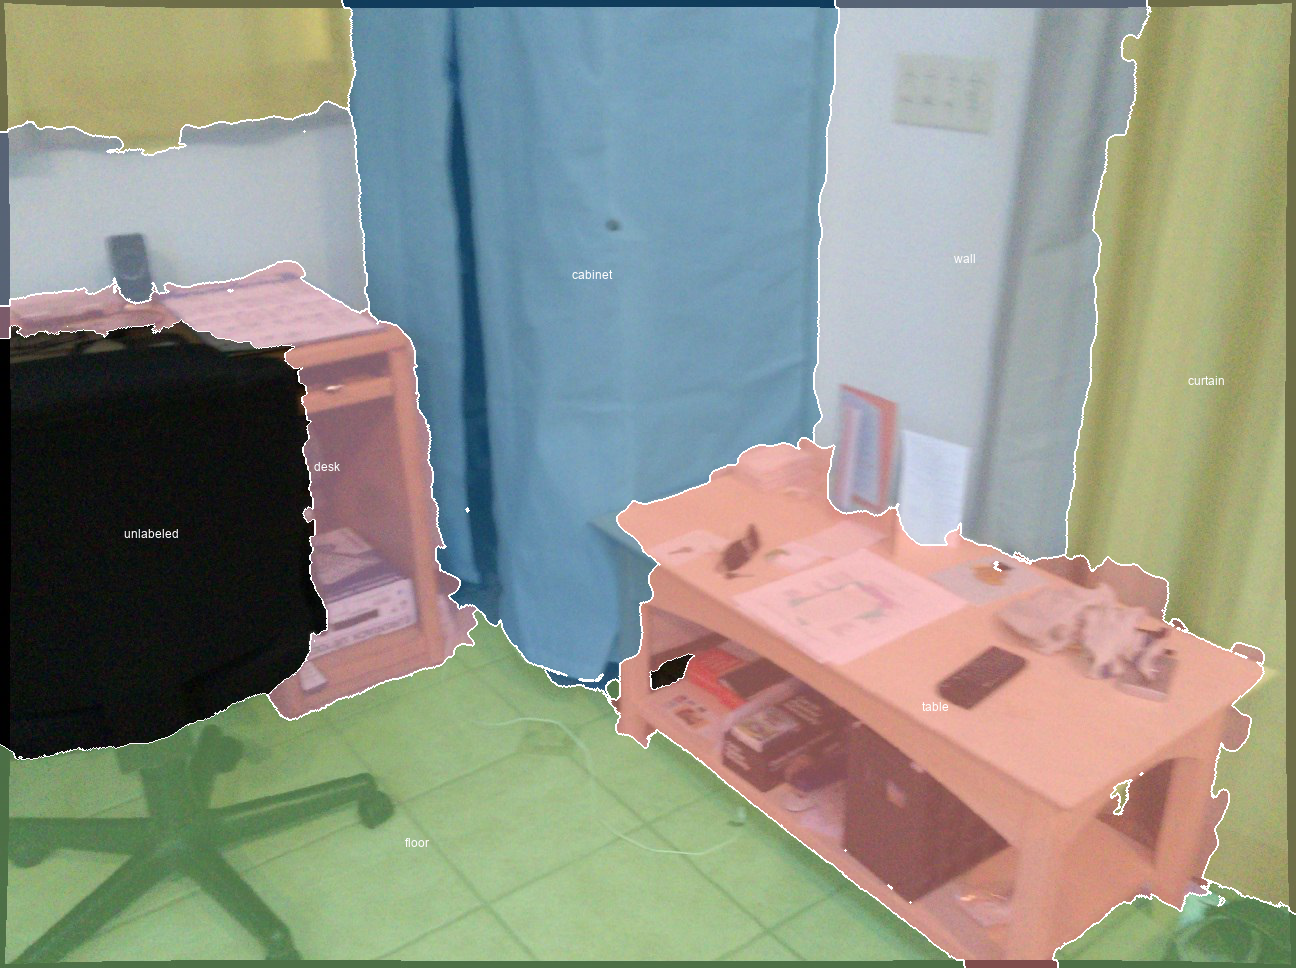

In [161]:
accm = AccMonitor()
acc = np.zeros( (len(img_p),41))

ac = []
for i in range(0, len(img_p)):
    gt = lla.get(gt_p[i])[0]
    pred =lla.get(labels_52_retrained [i])[0]
    
    m = gt != 0
    ac.append( (gt[m] == pred[m]).sum() /gt.size)
    
    img = imageio.imread(img_p[i])
    ind, num= np.unique(gt, return_counts=True) 
    acc[i,ind] = num
    accm.update( "test", pred-1,gt-1)
    
    if i == 0:
        visu.plot_detectron(np.array( imageio.imread(img_p[i]) ), gt, jupyter=True)

In [167]:
np.array(ac).mean(), print(accm )

Acc-Monitor:
  test: Nr-Images: 558 , Avg-Acc: 0.6215315771474492  Avg-Acc: valid both 0.6215315771474492 



(0.6022952449877107, None)

In [162]:
x = -np.array(ac)
k = 20
idx = np.argpartition(x, -k)[-k:]  # Indices not sorted
index = idx[np.argsort(x[idx])][::-1] 
np.array(ac)[index ]

worst = acc[index].sum(axis=0)

worst.tolist()[1:]
labels = [str(i) for i in range(1,41) if i%2 ]
la = []
for i in range(40):
    if (i-1) %2 == 0:
        la.append(str(i+1))
    else:
        la.append(str(i+1))
labels= la        
metrics = {
          }


x = -np.array(ac)
k = 20
idx = np.argpartition(x, -k)[-k:]  # Indices not sorted
index = idx[np.argsort(x[idx])][::-1] 
np.array(ac)[index ]

worst = acc[index].sum(axis=0)
worst.tolist()[1:]

labels = [str(i) for i in range(1,41) if i%2 ]
la = []
for i in range(40):
    if (i-1) %2 == 0:
        la.append(str(i+1))
    else:
        la.append(str(i+1))
labels= la        

ran = np.random.randint(0,acc.shape[0],k )
metrics = {"Label-Statistic: Training": acc.sum(axis=0).tolist()[1:],
          "Label-Statistic: L-MAX": worst.tolist()[1:],
           "Label-Statistic: Random": acc[ran].sum(axis=0).tolist()[1:],
          "Label-Statistic: Coverage": acc[::28].sum(axis=0).tolist()[1:]
          }

40 40
40 40
40 40


<ipython-input-163-beafecae67de>:43: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i].set_ylim(0,  max( metrics[key])*1.2  )


40 40


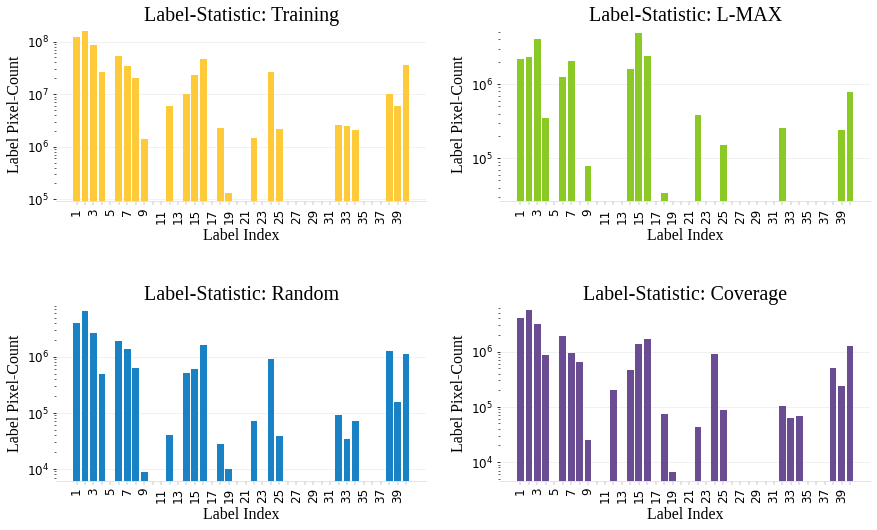

In [163]:
textwidth = 12.7 #cm
nr = 2
fig, ax = plt.subplots(2,nr , figsize=(textwidth, 7), sharex=False, sharey=False)
if nr ==1 : 
    ax = [ax]
left  = 0.1  # the left side of the subplots of the figure
right = 0.99    # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.6  # the amount of height reserved for white space between subplots
from visu.colors import *
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

#plt.setp(ax, yticks=[1, 2, 3])
ax = ax.reshape(-1)
for i,key in enumerate( metrics.keys()):
    print(len( labels), len(metrics[key]) )
    bars = ax[i].bar(labels, metrics[key], facecolor=COL_MAP(i+1),width =0.8)
    #ax[i].set_xlabel(key,fontsize=20, fontname= 'Liberation Serif' )
    ax[i].set_title(key,fontsize=20, fontname= 'Liberation Serif' )
    ax[i].set_ylabel("Label Pixel-Count",fontsize=16, fontname= 'Liberation Serif')
    ax[i].set_xlabel("Label Index",fontsize=16, fontname= 'Liberation Serif')
    ax[i].grid(True)
    ax[i].tick_params(axis="x", labelsize=12,rotation=90,width =2,color=(181/255, 181/255, 181/255, 0.36))
    ax[i].tick_params(axis="y", labelsize=12)

    # Axis formatting.
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')
    ax[i].set_yscale("log")
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)
    #ax[i].tick_params(bottom=False, left=False)
    ax[i].set_axisbelow(True)
    # Add text annotations to the top of the bars.

    j = 0
    
    if  metrics[key][j] > 0:
        ax[i].set_ylim(0,  max( metrics[key])*1.2  )
    else:
        ax[i].set_ylim(min( metrics[key])*1.4, max( metrics[key])*2  )
    bar_color = bars[0].get_facecolor()
    if metrics[key][0] < 0:
        ax[i].invert_yaxis()
    for j,bar in enumerate(bars):
      h = [ bar.get_height() for bar in bars]
      
      if  metrics[key][j] > 0 and i != 2: 
        bh = bar.get_height() + 0.05
        va = "bottom"
      elif metrics[key][j] > 0 and i == 2: 
        bh = bar.get_height() + 0.015
        va = "bottom"
        
      else:
        bh = bar.get_height() - 0.015
        va = "top"
      #ax[i].text(
      #    bar.get_x() + bar.get_width() / 2,
      #    bh ,
      #    round( metrics[key][j]  , 2),ha="center", va=va,
      #          color=bar_color,
      #weight='bold'
      #)
    
    for k,label in enumerate(ax[i].xaxis.get_ticklabels()):
        if k% 2 != 0:
            label.set_visible(False)
plt.show()
from visu.visualizer import get_img_from_fig
res = get_img_from_fig(fig, dpi=360)
imageio.imwrite( 'docs/bar_plot_label_statistics.png', res)


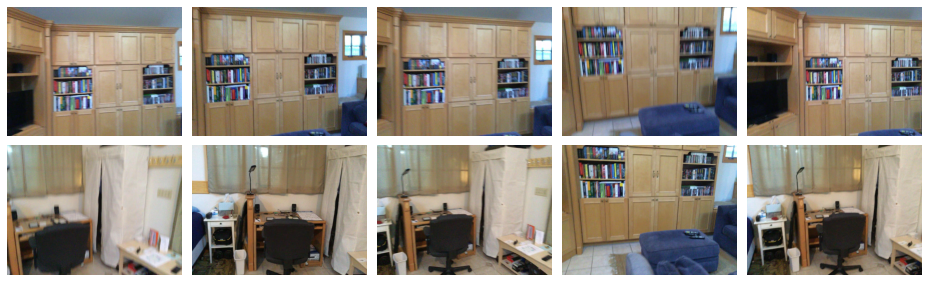

In [204]:
x = -np.array(ac)
k = 20
idx = np.argpartition(x, -k)[-k:]  # Indices not sorted
index = idx[np.argsort(x[idx])][::-1] 
imgs_plot = []
for i in index[:12]:
    imgs_plot.append( visu.plot_image(np.array( imageio.imread(img_p[i])[12:-12,12:-12] ),jupyter=False))
    
textwidth = 12.7 #cm
nr = 5
fig, ax = plt.subplots(2,nr , figsize=(textwidth, 3.8), sharex=False, sharey=False)
if nr ==1 : 
    ax = [ax]
left  = -0.005  # the left side of the subplots of the figure
right = 1.005    # the right side of the subplots of the figure
bottom = 0.01   # the bottom of the subplots of the figure
top = 0.99      # the top of the subplots of the figure
wspace = 0.009   # the amount of width reserved for blank space between subplots
hspace = 0.07 # the amount of height reserved for white space between subplots
from visu.colors import *
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

#plt.setp(ax, yticks=[1, 2, 3])
ax = ax.reshape(-1)
for k, im in enumerate(imgs_plot[:10]):
    ax[k].imshow(im)
    ax[k].axis('off')
plt.show()
from visu.visualizer import get_img_from_fig
res = get_img_from_fig(fig, dpi=360)
imageio.imwrite( 'docs/buffer_examples.png', res)
